<a href="https://colab.research.google.com/github/BenYavor/Autoencoder_communication_sytem_with_GAN_channel-estimation/blob/master/Communication_Autoencoder_with_GAN_alternating_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

#### Vergleich
Als erstes für feste $k$ und $n$, was sich ändert ist die Samplesize, Anzahl der Samples und SNR

###Systemparameter
ACHTUNG: CHANNELANZAHL WURDE UNTERSCHIEDLICH VERWENDET \\
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [2]:
k = 4      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2    # Number of real channel uses per message
#k = int(np.log2(M))
#n = 2
print(M)

SNR = 7


16


## Training Parameter

In [0]:
gen_learning_rate=0.0001 
disc_learning_rate = 0.0001                  # 0.0001  

### Different Layers

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(2*n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
# = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


#noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,n]))
channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

### Help functions

In [5]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(2*k/n)*ebno) 
    return noise_std


def real_channel(x,noise_std):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

    #Rayleigh
    #return x + tf.sqrt(tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random_normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg




def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(input_msg, tf.argmax(msg, 1))      
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

noise_std = EbNo2Sigma(SNR)

print(EbNo2Sigma(SNR))
print(EbNo_to_noise(SNR))

0.15792649852735607
0.15792649852735607


In [0]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()
  


# Models

#### Generator Model

In [0]:
def get_generator(n):
  input1 = tf.keras.layers.Input(shape=(n,))
  x1 = tf.keras.layers.Dense(n)(input1)
  input2 =tf.random.normal(shape=tf.shape(input1))
  #input2 =tf.random.normal([tf.shape(input1)[0],n])
  x2 = tf.keras.layers.Dense(n)(input2)
  subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
  h1 = tf.keras.layers.Dense(64,use_bias=True, kernel_initializer=randN_initial, activation='relu')(subtracted)
  h2 = tf.keras.layers.Dense(64,use_bias=True,kernel_initializer=randN_initial, activation='relu')(h1)
  out = tf.keras.layers.Dense(n, use_bias= True,kernel_initializer=randN_initial, activation='linear')(h2)
  generator = tf.keras.models.Model(inputs=[input1], outputs=out)
  return generator


#### Discriminator Model 

In [0]:
def get_discriminator(n):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial,activation='relu',input_shape=((2*n,))))
  model.add(tf.keras.layers.Dense(32,use_bias=True, kernel_initializer=randN_initial, activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid'))
  return model
  

In [0]:
generator = get_generator(n)
discriminator=get_discriminator(n)

## Encoder Model

In [0]:
def get_gan_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M*2, kernel_initializer=randN_initial,activation="elu"),
            keras.layers.Dense(M*2,kernel_initializer=randN_initial, activation="elu"),
            keras.layers.Dense(n, kernel_initializer=randN_initial, activation=None),
            e2,
            EncOut,
            GenIn])
  return model

## Decoder Model

In [0]:
def get_gan_decoder(M):
   model= keras.models.Sequential([
                #DecIn,
                #d1,
                keras.layers.Input(shape=(n,)),
                keras.layers.Dense(M*2,kernel_initializer=randN_initial, activation="elu"),
                keras.layers.Dense(M*2,kernel_initializer=randN_initial, activation="elu"),
                keras.layers.Dense(M,kernel_initializer=randN_initial, activation="softmax")
                ])
   return model

### GAN Training functions

In [0]:
def gan_optimizers(gen_learning_rate  ,disc_learning_rate):
  generator_optimizer = tf.keras.optimizers.RMSprop(gen_learning_rate)      #RMSprop   in oreder to test where the error comes from
  discriminator_optimizer = tf.keras.optimizers.RMSprop(disc_learning_rate) 
  return generator_optimizer, discriminator_optimizer

In [13]:
%%time
def train_gan(epochs,n_steps, batch_size, SNR_level):
  noise_std = EbNo2Sigma(SNR_level)
  start = time.time()
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    counter += 1
    train_step(noise_std, n_steps,batch_size)
    if counter%100==0:
      tf.print("counter %d:" % (counter))
      fake_c = generator(x)
      tf.print(fake_c[0])
    #print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
      tf.print ('Time for epoch {},'.format(epoch + 1))
      
  tf.saved_model.save(generator,'/tmp/saved_model/')
  tf.print ('Time for the training is {} sec,'.format( time.time()-start))
    

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.68 µs


In [0]:
@tf.function
def train_step(noise_std,n_steps,batch_size):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  m =random_sample(batch_size)
  r = encoder(m)
  for i in range(n_steps):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_training_data = tf.concat(values=[real_channel(r,noise_std), r], axis=1)
      fake_training_data = tf.concat(values=[generator(r),r], axis=1)
      real_output = discriminator(real_training_data)
      fake_output = discriminator(fake_training_data)
      
      
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))
      gen_loss =-tf.reduce_mean(tf.math.log(fake_output))
      
      #tf.print(disc_loss,gen_loss)
      
      if tf.math.is_nan(disc_loss) == False:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
      if i == 4:  
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



In [0]:
def creating_and_train_gan(epochs,n_steps, batch_size, SNR_level , n ):  #optional Leraning Rates
  generator.trainable = True
  train_gan(epochs, n_steps, batch_size, SNR_level)
  #4 after GAN training
  generator.trainable = False
  #tf.print(generator.trainable)

In [0]:
def gan_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

def w_gan_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = w_gan_encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = w_gan_decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)


# Resiver Training

In [0]:
decoder = get_gan_decoder(M)
encoder = get_gan_encoder(M)


channel_layer = keras.layers.Lambda(lambda x: real_channel(x,noise_std))

# Decoder Training

In [0]:
data = random_sample(100)

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_object_a = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
decoder_optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0005)

def decoder_loss(decoder, x, y):
  x_ = encoder(x)
  y1= channel_layer(x_)
  y_ = decoder(y1)
  return loss_object(y_true=y, y_pred=y_)

@tf.function
def decoder_grad(model, inputs, targets):
  with tf.GradientTape() as decoder_tape:
    loss_value = decoder_loss(model, inputs, targets)
  return loss_value, decoder_tape.gradient(loss_value, model.trainable_variables)



In [0]:

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

def decoder_training(num_epochs, batch_size = 400):
  for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    data = random_sample(batch_size)
    loss_value = decoder_step_training()
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(data, decoder(channel_layer(encoder(data))))   
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 500 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                      epoch_accuracy.result()))
@tf.function                                                                
def decoder_step_training():
  loss_value, decoder_grads = decoder_grad(decoder, data, data)
  decoder_optimizer.apply_gradients(zip(decoder_grads, decoder.trainable_variables))
  return loss_value  


# Transmitter Training

In [0]:
encoder_optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0005)

def encoder_loss(encoder, x, y):
  x_ = encoder(x)
  y1= generator(x_)
  y_ = decoder(y1)
  return loss_object_a(y_true=y, y_pred=y_)

@tf.function
def encoder_grad(model, inputs, targets):
  with tf.GradientTape() as encoder_tape:
    loss_value = encoder_loss(model, inputs, targets)
  return loss_value, encoder_tape.gradient(loss_value, model.trainable_variables)



In [22]:
loss_value, encoder_grads = encoder_grad(encoder,data, data)

print("Step: {}, Initial Loss: {}".format(encoder_optimizer.iterations.numpy(),
                                          loss_value.numpy()))

encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))

print("Step: {},         Loss: {}".format(encoder_optimizer.iterations.numpy(),
                                          encoder_loss(encoder, data, data).numpy()))


Step: 0, Initial Loss: 2.7725884914398193
Step: 1,         Loss: 2.7725887298583984


In [0]:

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

def encoder_training(num_epochs, batch_size = 400):
  for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    data = random_sample(batch_size)

    loss_value = encoder_step_training()
      #loss_value, encoder_grads = encoder_grad(encoder, data, data)
      #encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(data, decoder(generator(encoder(data))))  
   # train_loss_results.append(epoch_loss_avg.result())
   # train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 500 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
@tf.function
def encoder_step_training():
  loss_value, encoder_grads = encoder_grad(encoder, data, data)
  encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))
  return loss_value



# GAN Training

Epoch 000: Loss: 2.773, Accuracy: 10.000%
Epoch 500: Loss: 2.504, Accuracy: 35.000%
Epoch 1000: Loss: 2.426, Accuracy: 61.000%
Epoch 1500: Loss: 2.396, Accuracy: 50.000%
Epoch 2000: Loss: 2.402, Accuracy: 53.000%
Epoch 000: Loss: 2.788, Accuracy: 8.000%


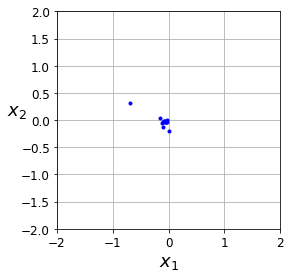

counter 100:
[-0.0338680446 -0.0262110867]
Time for epoch 100,
counter 200:
[-0.0759057328 -0.0241536163]
Time for epoch 200,
counter 300:
[-0.0570387356 -0.0190118533]
Time for epoch 300,
counter 400:
[0.280034274 -0.145138189]
Time for epoch 400,
counter 500:
[-0.060001187 -0.105502494]
Time for epoch 500,
counter 600:
[0.0278535113 -0.406077474]
Time for epoch 600,
counter 700:
[0.144187689 0.0725884214]
Time for epoch 700,
counter 800:
[0.813941717 -0.69467175]
Time for epoch 800,
counter 900:
[0.784265816 -0.369710684]
Time for epoch 900,
counter 1000:
[0.841565788 -0.6781618]
Time for epoch 1000,
counter 1100:
[1.40160429 -0.845050812]
Time for epoch 1100,
counter 1200:
[1.29990697 -0.54653883]
Time for epoch 1200,
counter 1300:
[0.996227086 -0.659106135]
Time for epoch 1300,
counter 1400:
[0.545277655 -0.755126894]
Time for epoch 1400,
counter 1500:
[0.96983391 -0.568605781]
Time for epoch 1500,
counter 1600:
[0.364972651 -0.075308077]
Time for epoch 1600,
counter 1700:
[0.95710

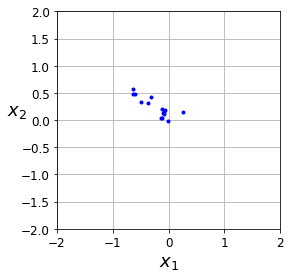

counter 100:
[0.246452779 -0.214264646]
Time for epoch 100,
counter 200:
[0.373433232 -0.196188793]
Time for epoch 200,
counter 300:
[-0.150818944 -0.0784258619]
Time for epoch 300,
counter 400:
[0.320035279 -0.0761097744]
Time for epoch 400,
counter 500:
[0.0145780556 -0.229499608]
Time for epoch 500,
counter 600:
[0.352762 0.276369393]
Time for epoch 600,
counter 700:
[0.0325318761 -0.105316967]
Time for epoch 700,
counter 800:
[0.226044387 0.0374112315]
Time for epoch 800,
counter 900:
[0.225851044 0.0418643802]
Time for epoch 900,
counter 1000:
[0.20469825 0.185937822]
Time for epoch 1000,
counter 1100:
[0.0973945409 0.235228181]
Time for epoch 1100,
counter 1200:
[0.142513081 0.254316539]
Time for epoch 1200,
counter 1300:
[0.223735631 0.143618613]
Time for epoch 1300,
counter 1400:
[0.0937580764 0.138557374]
Time for epoch 1400,
counter 1500:
[0.141108096 0.0268181749]
Time for epoch 1500,
counter 1600:
[0.182506964 -0.0428198054]
Time for epoch 1600,
counter 1700:
[0.0989356637 

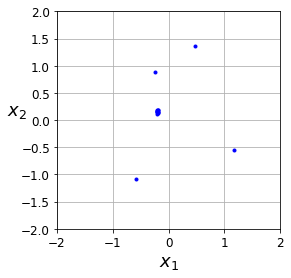

Epoch 000: Loss: 2.672, Accuracy: 20.000%
Epoch 500: Loss: 2.643, Accuracy: 22.000%
Epoch 1000: Loss: 2.628, Accuracy: 24.000%
Epoch 1500: Loss: 2.629, Accuracy: 26.000%
Epoch 2000: Loss: 2.628, Accuracy: 26.000%
counter 100:
[0.035664171 0.124103352]
Time for epoch 100,
counter 200:
[0.117873251 0.244908825]
Time for epoch 200,
counter 300:
[-0.0823011622 -0.112259194]
Time for epoch 300,
counter 400:
[-0.237354502 -0.00155286677]
Time for epoch 400,
counter 500:
[0.100326642 0.105327696]
Time for epoch 500,
counter 600:
[-0.0268536378 0.20832102]
Time for epoch 600,
counter 700:
[0.235295385 0.0185813811]
Time for epoch 700,
counter 800:
[-0.36444056 -0.00168022187]
Time for epoch 800,
counter 900:
[0.0362655818 0.554163039]
Time for epoch 900,
counter 1000:
[0.0376389287 0.403662145]
Time for epoch 1000,
counter 1100:
[0.0343756154 0.331653088]
Time for epoch 1100,
counter 1200:
[0.360223204 0.49715206]
Time for epoch 1200,
counter 1300:
[0.540384591 0.236621156]
Time for epoch 1300

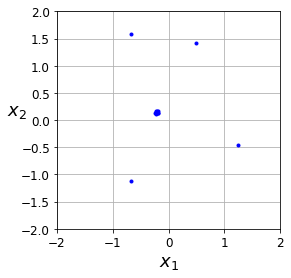

Epoch 000: Loss: 2.626, Accuracy: 18.000%
Epoch 500: Loss: 2.625, Accuracy: 25.000%
Epoch 1000: Loss: 2.624, Accuracy: 24.000%
Epoch 1500: Loss: 2.625, Accuracy: 29.000%
Epoch 2000: Loss: 2.624, Accuracy: 22.000%
counter 100:
[0.315612733 -1.02429152]
Time for epoch 100,
counter 200:
[0.332114428 -0.744641]
Time for epoch 200,
counter 300:
[0.265648812 -0.891668081]
Time for epoch 300,
counter 400:
[0.455155045 -0.845303655]
Time for epoch 400,
counter 500:
[0.587257385 -0.961380243]
Time for epoch 500,
counter 600:
[0.31078589 -0.789686441]
Time for epoch 600,
counter 700:
[0.31437102 -0.900503159]
Time for epoch 700,
counter 800:
[0.454925597 -0.663722456]
Time for epoch 800,
counter 900:
[0.679073393 -1.0941658]
Time for epoch 900,
counter 1000:
[0.629184663 -1.07253]
Time for epoch 1000,
counter 1100:
[0.431108654 -0.697046518]
Time for epoch 1100,
counter 1200:
[0.442158788 -0.997239]
Time for epoch 1200,
counter 1300:
[0.630392849 -1.01063812]
Time for epoch 1300,
counter 1400:
[

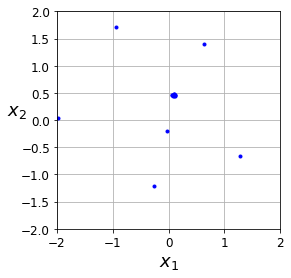

counter 100:
[0.183219627 0.440923244]
Time for epoch 100,
counter 200:
[-0.0371069238 0.16079849]
Time for epoch 200,
counter 300:
[0.078466408 -0.128750667]
Time for epoch 300,
counter 400:
[-0.487231493 -0.205740348]
Time for epoch 400,
counter 500:
[0.0142424442 0.00402496103]
Time for epoch 500,
counter 600:
[-0.074154146 -0.10071075]
Time for epoch 600,
counter 700:
[0.0801699311 -0.00494847354]
Time for epoch 700,
counter 800:
[0.182361662 -0.105080247]
Time for epoch 800,
counter 900:
[0.11048691 -0.1380997]
Time for epoch 900,
counter 1000:
[-0.112254113 0.18028602]
Time for epoch 1000,
counter 1100:
[0.110323206 -0.0457151793]
Time for epoch 1100,
counter 1200:
[0.0449392349 0.0751791894]
Time for epoch 1200,
counter 1300:
[-0.0260789152 0.0379175395]
Time for epoch 1300,
counter 1400:
[0.0438440479 -0.117102228]
Time for epoch 1400,
counter 1500:
[0.068242684 0.191552594]
Time for epoch 1500,
counter 1600:
[-0.0168082379 0.0446211137]
Time for epoch 1600,
counter 1700:
[-0.1

In [24]:
%%time
generator_optimizer, discriminator_optimizer = gan_optimizers(gen_learning_rate=gen_learning_rate, disc_learning_rate = disc_learning_rate)
start = time.time()
decoder_training(2001, 100)
encoder_training(101, 100)
test_encoding(M,n)
creating_and_train_gan(epochs= 4000,n_steps=5, batch_size =100, SNR_level = 7, n = n)
encoder_training(2001, 100)
test_encoding(M,n)
creating_and_train_gan(epochs= 4000,n_steps=5, batch_size =100, SNR_level = 7, n = n)
encoder_training(2000, 100)
test_encoding(M,n)
decoder_training(2001, 100)
creating_and_train_gan(epochs= 4000,n_steps=5, batch_size =100, SNR_level = 7, n = n)
encoder_training(500, 100)
test_encoding(M,n)
decoder_training(2001, 100)
creating_and_train_gan(epochs= 4000,n_steps=5, batch_size =100, SNR_level = 7, n = n)
encoder_training(2000, 100)
decoder_training(2001, 100)
creating_and_train_gan(epochs= 4000,n_steps=5, batch_size =100, SNR_level = 7, n = n)
encoder_training(2000, 100)
test_encoding(M,n)
creating_and_train_gan(epochs= 4000,n_steps=5, batch_size =100, SNR_level = 7, n = n)
time_to_train_gan = time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))

Train on 10000000 samples
Epoch 1/20
   50000/10000000 [..............................] - ETA: 1:45 - loss: 0.1849 - accuracy: 0.9353

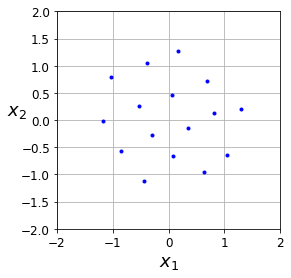

CPU times: user 16.9 s, sys: 569 ms, total: 17.4 s
Wall time: 13.6 s


In [25]:
%%time
generator.trainable =False
encoder.trainable = True
decoder.trainable = True
gan_AE = tf.keras.models.Sequential([encoder,generator,decoder])
data = random_sample(10000000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=100, epochs=20)

test_encoding(M,n)


# AE training

In [0]:
# test msg sequence for normal encoding
N_test = 500000
test_msg = np.random.randint(M, size=N_test)

### Comparison

In [27]:
gan_bber_data = gan_Test_AE(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


time to train the AE Model with GAN 339.4015271663666


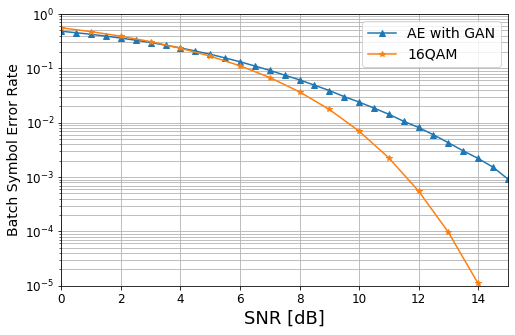

In [28]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], '^-')
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '*-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with GAN', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")
print('time to train the AE Model with GAN',time_to_train_gan)


In [0]:
#generator.summary()

In [30]:
print(gan_bber_data[1])

[<tf.Tensor: id=2000889, shape=(), dtype=float32, numpy=0.481228>, <tf.Tensor: id=2000951, shape=(), dtype=float32, numpy=0.45184>, <tf.Tensor: id=2001013, shape=(), dtype=float32, numpy=0.422872>, <tf.Tensor: id=2001075, shape=(), dtype=float32, numpy=0.391328>, <tf.Tensor: id=2001137, shape=(), dtype=float32, numpy=0.360266>, <tf.Tensor: id=2001199, shape=(), dtype=float32, numpy=0.329052>, <tf.Tensor: id=2001261, shape=(), dtype=float32, numpy=0.298066>, <tf.Tensor: id=2001323, shape=(), dtype=float32, numpy=0.266816>, <tf.Tensor: id=2001385, shape=(), dtype=float32, numpy=0.237354>, <tf.Tensor: id=2001447, shape=(), dtype=float32, numpy=0.208756>, <tf.Tensor: id=2001509, shape=(), dtype=float32, numpy=0.18174>, <tf.Tensor: id=2001571, shape=(), dtype=float32, numpy=0.155398>, <tf.Tensor: id=2001633, shape=(), dtype=float32, numpy=0.13223>, <tf.Tensor: id=2001695, shape=(), dtype=float32, numpy=0.110582>, <tf.Tensor: id=2001757, shape=(), dtype=float32, numpy=0.091774>, <tf.Tensor: 